# LSTM Hidden State Projection

In this notebook, we will use t-SNE projection to analyse how hidden states of a LSTM layer change over the timesteps of the input sequence.

In [264]:
import numpy as np
import random
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence as sq
from keras.optimizers import RMSprop

from sklearn.manifold import TSNE

We train a LSTM model with the IMDB dataset. The purpose is to predict if a review is positive or negative.

In [2]:
# Load the dataset.
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# Truncate and pad input sequences (fill with zeros if fewer words then max length).
x_train = sq.pad_sequences(x_train, maxlen=100)
x_test = sq.pad_sequences(x_test, maxlen=100)

In [130]:
# Create a dict to transform word id into string.
word_to_id = imdb.get_word_index()
word_to_id = {k: (v + 3) for k, v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {v: k for k, v in word_to_id.items()}

In [3]:
# Instantiate the layers of the model.
embedd = Embedding(input_dim=(np.max(x_train) + 1), output_dim=32, input_length=x_train.shape[1])
conv_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')
pool_1 = MaxPooling1D(pool_size=2)
drop_1 = Dropout(0.25)
lstm_1 = LSTM(units=100)
drop_2 = Dropout(0.5)
output = Dense(units=1, activation='sigmoid')

model = Sequential()
model.add(embedd)
model.add(conv_1)
model.add(pool_1)
model.add(drop_1)
model.add(lstm_1)
model.add(drop_2)
model.add(output)

In [4]:
# Train the model,
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
h = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 40s 2ms/step - loss: 0.5030 - acc: 0.7576 - val_loss: 0.3544 - val_acc: 0.8476
Epoch 2/5
22500/22500 [==============================] - 34s 2ms/step - loss: 0.2998 - acc: 0.8801 - val_loss: 0.3622 - val_acc: 0.8512
Epoch 3/5
22500/22500 [==============================] - 34s 2ms/step - loss: 0.2309 - acc: 0.9122 - val_loss: 0.3402 - val_acc: 0.8552
Epoch 4/5
22500/22500 [==============================] - 34s 2ms/step - loss: 0.1873 - acc: 0.9340 - val_loss: 0.3997 - val_acc: 0.8416
Epoch 5/5
22500/22500 [==============================] - 34s 2ms/step - loss: 0.1575 - acc: 0.9448 - val_loss: 0.6545 - val_acc: 0.7948


In [5]:
# Predictions of the test set.
y_pred = model.predict(x_test)

# Evaluate the model.
scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.30%


We transfer the weights to two other models:
* One to return the hidden state of the LSTM layer at each timestep.
* One to give the prediction of the original model based in a particular hidden state.

In [6]:
# Transfer weight to a new model to get LSTM activations.
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=(np.max(x_train) + 1), output_dim=32, input_length=x_train.shape[1]))
model_rnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_rnn.add(MaxPooling1D(pool_size=2))
model_rnn.add(Dropout(0.25))
model_rnn.add(LSTM(units=100, return_sequences=True))

model_rnn.layers[0].set_weights(model.layers[0].get_weights())
model_rnn.layers[1].set_weights(model.layers[1].get_weights())
model_rnn.layers[4].set_weights(model.layers[4].get_weights())

In [7]:
# Transfer weights of the classification layer to generate outputs for each state.
model_reg = Sequential()
model_reg.add(Dense(units=1, activation='sigmoid', input_shape=(model_rnn.output_shape[-1],)))

model_reg.layers[0].set_weights(model.layers[6].get_weights())

We calculate the hidden state for every timestep of 100 observations from the test set. We put them all in a single dataset (this has to be done differently in the future) and we apply tsne to it.

In [19]:
# Generate the hidden states for every timestep in the first N observations of the training set.
hidden_states = model_rnn.predict(x_test[:100])

# Reshape in a single dataset.
hs_shape = hidden_states.shape
hidden_states = hidden_states.reshape((hidden_states.shape[0]*hidden_states.shape[1], hidden_states.shape[2]))

In [20]:
# Get the model output for every hidden state generated above.
model_outputs = model_reg.predict(hs_input)

In [22]:
# Project all the hidden states to 
tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=12.0, verbose=1).fit(hidden_states)
projection = tsne.embedding_
divergence = tsne.kl_divergence_

divergence

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.091s...
[t-SNE] Computed neighbors for 5000 samples in 2.422s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.545704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.704689
[t-SNE] Error after 1000 iterations: 1.217720


1.21772038936615

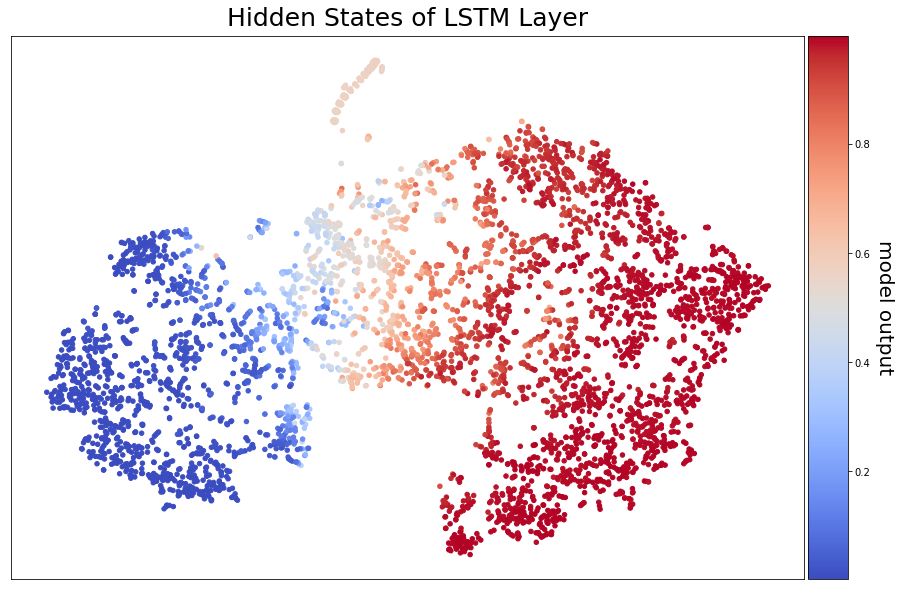

In [29]:
# Display the hidden state projection as a scatterplot.
f, ax = plt.subplots(figsize=(15, 10))
    
# Plot points as a scatterplot.
im = plt.scatter(projection[:, 0], projection[:, 1], c=model_outputs[:, 0], cmap=cm.coolwarm, s=20)

# Plot the colorbar.
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(im, cax=cax)
cbar.ax.set_ylabel("model output", rotation=-90, va="bottom", fontsize=20)

# Set titles.
ax.set_title('Hidden States of LSTM Layer', fontsize=25, pad=10)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In this scatterplot, datapoints represent one hidden state in a particular timestep for a particular input. Hidden states are colored by the output they generate if given as input to the last layer of the model. The color/output of a hidden state from an intermediate step MAY BE DIFFERENT from the the output of the final hidden state after the whole sequence has been processed.

We can see two clear regions for the two possible outputs: negative (blue) and positive (red).

### Testing a sequence

Now we are going to analyse the hidden states of a particular sequence (review):

In [103]:
# Retrieve the s-th sequence from the dataset.
s = 0
sequence = projection.reshape((hs_shape[0], hs_shape[1], 2))[s, :, :]

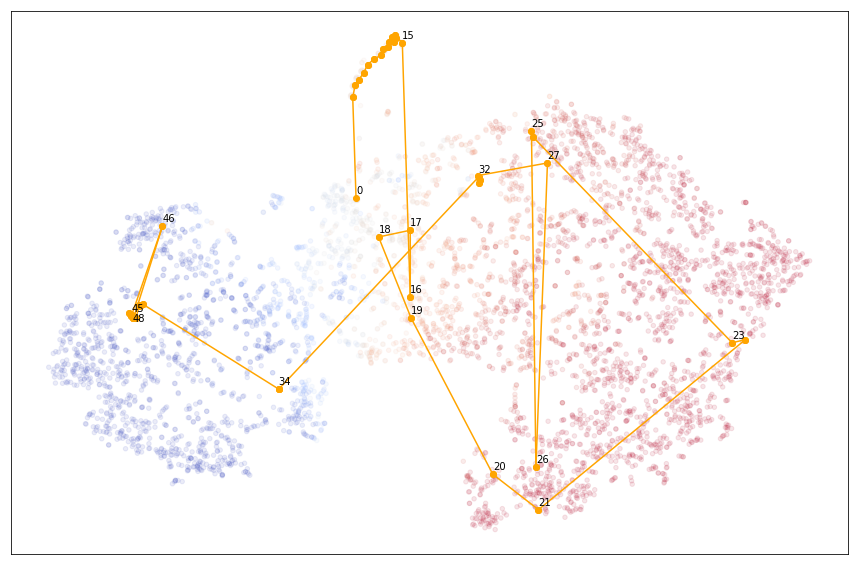

In [215]:
f, ax = plt.subplots(figsize=(15, 10))

im = plt.scatter(projection[:, 0], projection[:, 1], c=model_outputs[:, 0], cmap=cm.coolwarm, s=20, alpha=0.1)

for i, (p1, p2) in enumerate(zip(sequence, sequence[1:])):
    x = np.linspace(p1[0], p2[0], 100)
    y = np.linspace(p1[1], p2[1], 100)
    
    plt.plot(p1[0], p1[1], 'o', color='orange')
    plt.plot(p2[0], p2[1], 'o', color='orange')
    plt.plot(x, y, color='orange')

    # Plot unit indexes.
    if math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) > 5 or i == 0 or i == sequence.shape[0]-2:
        if math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) > 5:
            ax.annotate(str(i), (p1[0], p1[1] + 1))
        else:
            ax.annotate(str(i), (p1[0], p1[1] - 1))
    
# Remove ticks
ax.set_xticks([])
ax.set_yticks([])    

plt.show()

The model begins the sequence analysis considering the review to be more positive, but changes its mind at step 32 to 33, lets try to find out why:

In [216]:
# Transform words on the sentence from int id to words.
review = [id_to_word[x] for x in x_test[s]]

(' '.join(w for w in review))

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [217]:
# Group words in groups of three in the same way the conv layer does. Add padding first.
sentence = list(review)
sentence.append('<PAD>')
sentence.insert(0, '<PAD>')
sentence = [(w1, w2, w3) for w1, w2, w3 in zip(sentence, sentence[1:], sentence[2:])]

# Group words joining two consecutive groups in the same way the pooling layer does.
sentence = [(w1, w2, w3, w6) for (w1, w2, w3), (w4, w5, w6) in zip(sentence[::2], sentence[1::2])]

Lets observe which parts of the sentence are responsible to the key jumpings of the hidden state value. We start by step 16, where the first big jump is noticed.

In [218]:
sentence[16]

('<PAD>', '<START>', 'please', 'give')

The sentence padding ends and the model starts to actually read the review. The model jumps a lot in the next steps, but it only goes to a region with a strong degree of output confidence in step 20.

In [219]:
sentence[20]

('br', 'br', 'kristy', 'swanson')

The model seems to be considering the name of the actress as an indication of a positive review. Maybe most of the time she (or artist with similar names) is mentioned in the dataset the review is positive?

Lets check the jump in step 22.

In [220]:
sentence[22]

('and', 'the', 'rest', 'of')

The model jumped significantly, but to a region still with strong confidence in a positive review. Maybe this happens because of the sentence structure?

Lets check the jump in step 24.

In [221]:
sentence[24]

('the', 'cast', 'rendered', 'terrible')

The word 'terrible' made the hidden state jump to an area with more incertitude of the correct output. Makes sense, as this is usually a negative word.

Lets check the jump in step 26.

In [222]:
sentence[26]

('performances', 'the', 'show', 'is')

It's weird that after reading 'the terrible performance' the hidden state jumped to a region with a more positive output. Maybe the model is preparing to use what comes after 'is' to decide where to go next?

Lets check the jump in step 27.

In [223]:
sentence[27]

('show', 'is', 'flat', 'flat')

The adjective after 'is' really seems to be what makes it jump this time.

In the next time step, the hidden step returns to a zone of incertitude.

In [224]:
sentence[28]

('flat', 'flat', 'flat', 'br')

This defines the end of a phrase. Maybe it learns to identify the end of an affirmation (i.e., a finished opinion)?

It jumps to negative output in step 33.

In [225]:
sentence[33]

('madison', 'could', 'have', 'allowed')

The sentence "i don't know how michael madison could have allowed" seems to be the one throwing the hidden state to the "negative region".

It jumps again in step 35.

In [226]:
sentence[35]

('this', 'one', 'on', 'his')

This part seems to give more confidence to the model about the prediction, as the hidden state doesn't really get out from this region anymore. Except for a small jump on step 46.

In [227]:
sentence[46]

('so', 'all', 'you', 'madison')

Again, the name of the artist seems to introduce a significant change in the hidden state, even though is not changing the prediction.

### Testing another sequence

In [243]:
# Retrieve the s-th sequence from the dataset.
s = 7
sequence = projection.reshape((hs_shape[0], hs_shape[1], 2))[s, :, :]

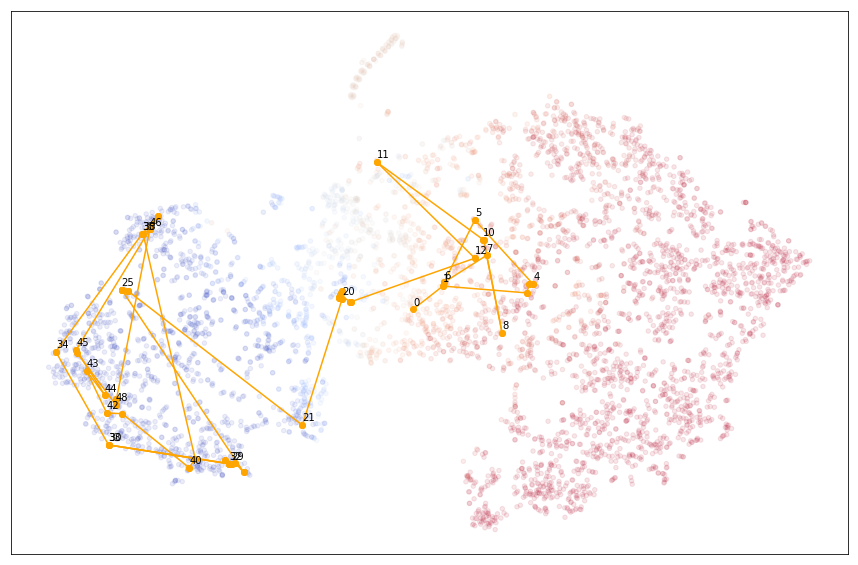

In [244]:
f, ax = plt.subplots(figsize=(15, 10))

im = plt.scatter(projection[:, 0], projection[:, 1], c=model_outputs[:, 0], cmap=cm.coolwarm, s=20, alpha=0.1)

for i, (p1, p2) in enumerate(zip(sequence, sequence[1:])):
    x = np.linspace(p1[0], p2[0], 100)
    y = np.linspace(p1[1], p2[1], 100)
    
    plt.plot(p1[0], p1[1], 'o', color='orange')
    plt.plot(p2[0], p2[1], 'o', color='orange')
    plt.plot(x, y, color='orange')

    # Plot unit indexes.
    if math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) > 5 or i == 0 or i == sequence.shape[0]-2:
        if math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) > 5:
            ax.annotate(str(i), (p1[0], p1[1] + 1))
        else:
            ax.annotate(str(i), (p1[0], p1[1] - 1))
    
# Remove ticks
ax.set_xticks([])
ax.set_yticks([])    

plt.show()

In [245]:
# Transform words on the sentence from int id to words.
review = [id_to_word[x] for x in x_test[s]]

(' '.join(w for w in review))

"the film passes by with romance and at the end johanna's dog gives birth but who is the father br br the dog story is the very weak vehicle that is used to try and create a story between humans its a terrible storyline there are 3 main musical pieces all of which are rubbish bad songs and dreadful choreography its just an extremely boring film bing has too many words in each sentence and delivers them in an almost irritating manner its not funny ever but its meant to be bing and joan have done much better than this"

In [246]:
# Group words in groups of three in the same way the conv layer does. Add padding first.
sentence = list(review)
sentence.append('<PAD>')
sentence.insert(0, '<PAD>')
sentence = [(w1, w2, w3) for w1, w2, w3 in zip(sentence, sentence[1:], sentence[2:])]

# Group words joining two consecutive groups in the same way the pooling layer does.
sentence = [(w1, w2, w3, w6) for (w1, w2, w3), (w4, w5, w6) in zip(sentence[::2], sentence[1::2])]

In step 13, it jumps from a more positive output to a more negative one.

In [248]:
sentence[12], sentence[13]

(('story', 'is', 'the', 'very'), ('the', 'very', 'weak', 'vehicle'))

The word 'weak' seems to be responsible. The prediction jumps to a more negative one in steps 20 -> 21.

In [249]:
sentence[20], sentence[21]

(('humans', 'its', 'a', 'terrible'), ('a', 'terrible', 'storyline', 'there'))

The model reads the expression 'terrible storyline' here.